<a href="https://colab.research.google.com/github/dancansikuku94/year4/blob/main/TB_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(101)
#from tensorflow import set_random_seed
#set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Total number of images i have in each class
NUM_AUG_IMAGES_WANTED = 1000 

# Resizing the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [ ]:
os.listdir('/content/drive/MyDrive/TB')

['ChinaSet_AllFiles', 'Montgomery']

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png')))
print(len(os.listdir('/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png')))

663
139


In [ ]:
shen_image_list = os.listdir('/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png')

In [ ]:
# putting the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# removing the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index 
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [ ]:
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0004_0.png
2,CHNCXR_0005_0.png
3,CHNCXR_0006_0.png
4,CHNCXR_0328_1.png


In [ ]:
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


In [ ]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.
#0 -> 0 meaning Normal
def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [ ]:
# Assigning  the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [ ]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [ ]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [ ]:
# Shenzen Dataset

IMAGE_PATH = '/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

NameError: ignored

In [ ]:
# Montgomery Dataset

IMAGE_PATH = '/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

NameError: ignored

In [ ]:
def read_image_sizes(file_name):
    
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
2,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0
3,CHNCXR_0006_0.png,Normal,2948,2775,3,255,0
4,CHNCXR_0328_1.png,Tuberculosis,2939,2985,3,255,0


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


In [ ]:
df_shen['c'].value_counts()

In [ ]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [ ]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [ ]:
### Here am combining the two dataframes

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [ ]:
# Creating a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [ ]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
127,CHNCXR_0411_1.png,Tuberculosis,2944,2994,3,255,0,1
684,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0,0
288,CHNCXR_0573_1.png,Tuberculosis,2988,2519,3,255,0,1
458,CHNCXR_0120_0.png,Normal,2945,3000,3,255,0,0
530,CHNCXR_0194_0.png,Normal,2992,2991,3,255,0,0


In [ ]:
#splitting the dataset into training and testing
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [ ]:
#Number of  normal images and Tuberculosis images in my training
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [ ]:
#Number of normal images and Tuberculosis images in my Validation 
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

In [ ]:
# Creating a new dir
base_dir = '/content/drive/MyDrive/DIR/base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


FileExistsError: ignored

In [ ]:
# Setting the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Getting a list of images in each of the two folders
folder_1 = os.listdir('/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png')

# Getting a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transferring the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to images
        src = os.path.join('/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to images
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # saving the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to images
        src = os.path.join('/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to images
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transferring the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/TB/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/TB/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

NameError: ignored

In [ ]:
# checking how many train images i have in each folder

print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/train_dir/Normal')))
print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/train_dir/Tuberculosis')))

345
335


In [ ]:
# checking how many validation images i have in each folder

print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/val_dir/Normal')))
print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/val_dir/Tuberculosis')))

*Data Augmentation

In [ ]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    #  creating temporary directories .
    # creating a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choosing a class
    img_class = item

    # listing all images in that directory
    img_list = os.listdir('/content/drive/MyDrive/DIR/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join('/content/drive/MyDrive/DIR/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '/content/drive/MyDrive/DIR/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [ ]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/train_dir/Normal')))
print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/train_dir/Tuberculosis')))

1035
1005


In [ ]:
# Check how many val images we have in each folder.

print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/val_dir/Normal')))
print(len(os.listdir('/content/drive/MyDrive/DIR/base_dir/val_dir/Tuberculosis')))

61
59


In [ ]:
plots(imgs, titles=None) # titles=labels will display the image labels

NameError: ignored

In [ ]:
train_path = '/content/drive/MyDrive/DIR/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/DIR/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=10, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/10
 3/68 [>.............................] - ETA: 1s - loss: 0.5832 - accuracy: 0.7000

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


68/68 [==============================] - 2s 28ms/step - loss: 0.5432 - accuracy: 0.7382 - val_loss: 0.5300 - val_accuracy: 0.7417
Epoch 2/10
68/68 [==============================] - 2s 27ms/step - loss: 0.5397 - accuracy: 0.7441 - val_loss: 0.5449 - val_accuracy: 0.7583
Epoch 3/10
68/68 [==============================] - 2s 27ms/step - loss: 0.5128 - accuracy: 0.7544 - val_loss: 0.5124 - val_accuracy: 0.7417
Epoch 4/10
68/68 [==============================] - 2s 29ms/step - loss: 0.5440 - accuracy: 0.7324 - val_loss: 0.5289 - val_accuracy: 0.7333
Epoch 5/10
68/68 [==============================] - 2s 28ms/step - loss: 0.5217 - accuracy: 0.7441 - val_loss: 0.5501 - val_accuracy: 0.7333
Epoch 6/10
68/68 [==============================] - 2s 28ms/step - loss: 0.5122 - accuracy: 0.7618 - val_loss: 0.5302 - val_accuracy: 0.7417
Epoch 7/10
68/68 [==============================] - 2s 28ms/step - loss: 0.4853 - accuracy: 0.7706 - val_loss: 0.5085 - val_accuracy: 0.7917
Epoch 8/10
68/68 [======

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

OSError: ignored

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

KeyError: ignored

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

 1/12 [=>............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


12/12 [==============================] - 0s 19ms/step


In [ ]:
predictions.shape

(120, 2)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(120,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[48 13]
 [18 41]]


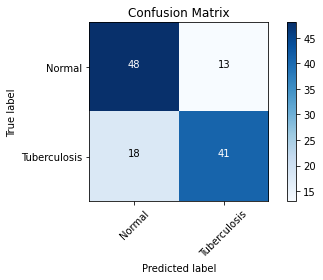

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      Normal       0.73      0.79      0.76        61
Tuberculosis       0.76      0.69      0.73        59

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120

